<a href="https://colab.research.google.com/gist/jonghank/30bb109d88df29b73b337f1ef3c62d80/more_optimal_control_problems_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More optimal control problems


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

This note talks about variations of optimal control problems with different objective functions and constraints. 

A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \R^n$, indexed by time $t\in \{0,\dots,N-1\}$ and dynamics equations

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bu_t 
\end{aligned}
$$

where $u_t\in\R^m$ is a control input to the dynamical system (say, a drive force or steering force on the vehicle). $A$ is the state transition matrix, $B$ is the input matrix.

Given $A$ and $B$, the goal is to find the optimal $u_0, \dots, u_{N-1}$ that drives the systems state to the desirable state. The optimality now can be described in a variety of more complicated convex functions and constraints.


<br>

---

## Minimum energy control revisited

Recall the minimum energy control problem which was described as follows.

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1
\end{aligned}
$$



We'll consider optimal vehicle guidance problem with state $x_t\in\R^4$, where the first two states are the position of the vehicle in two dimensions, and the last two are the vehicle velocity. The vehicle's control force $u_t\in\R^2$ is acceleration control for the two axes.

Then the following matrices describe the above dynamics.

$$
A = \bmat{
1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 0 & 1-\gamma\Delta t & 0 \\
0 & 0 & 0 & 1-\gamma\Delta t
} \\
B = \bmat{
0.5\Delta t^2 & 0 \\
0 & 0.5\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t
} 
$$

We consider the finite horizon of $T=50$, with $\Delta t=0.05$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

<br>

You may recall that we used the constraints describing the dynamical relations, $x_{t+1} = Ax_t + Bu_t$ in order to eleminate the state variables, $x_1, \dots,x_N$, from the optimization problem. That way we were able to express the problem as a standard form least norm problem with the optimization variable $u_0,\dots,u_{N-1}$. The resulting problem looked like

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \|u\|_2^2 \\
  \text{subject to} \quad & Gu = x_\text{des}-A^Nx_0
\end{aligned}
$$

where $G=\bmat{A^{N-1}B & A^{N-2}B & \cdots & AB & B}$ and $u=\bmat{u_1^T & \cdots & u_{N-1}^T}^T$. The desired final position and velocity vector is expressed in $x_\text{des}$ and $x_0$ describes the initial condition. 

The following was an implementation of this idea.

In [2]:
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

x_0 = np.array([10, -20, 15, -5])
x_des = np.array([100, 50, 0, 0])

G = np.zeros((4,2*N))

for i in range(N):
  G[:, 2*i:2*(i+1)] = np.linalg.matrix_power(A,max(0,N-i-1))@B

u_hat = sla.lsqr(G,x_des - np.linalg.matrix_power(A,N)@x_0)[0]

u_vec = u_hat

u_opt = u_vec.reshape(1000,2).T

x_opt = np.zeros((4,N+1))
x_opt[:,0] = x_0

for t in range(N):
    x_opt[:,t+1] = A.dot(x_opt[:,t]) + B.dot(u_opt[:,t])

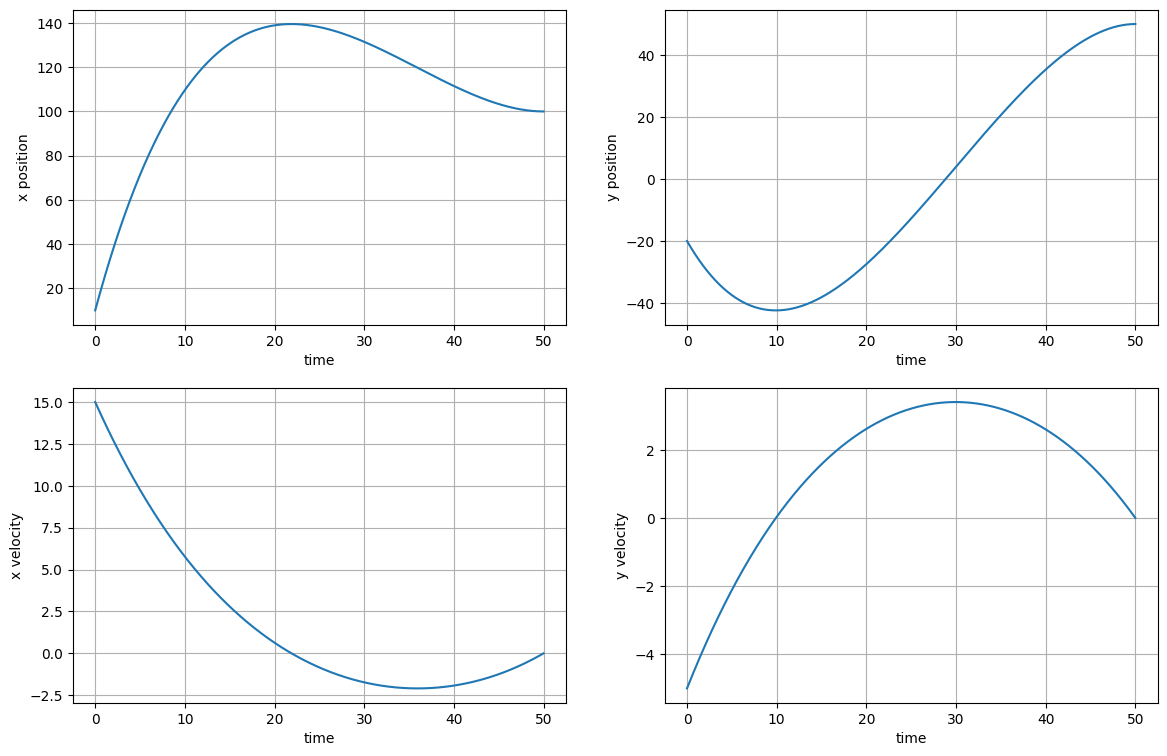

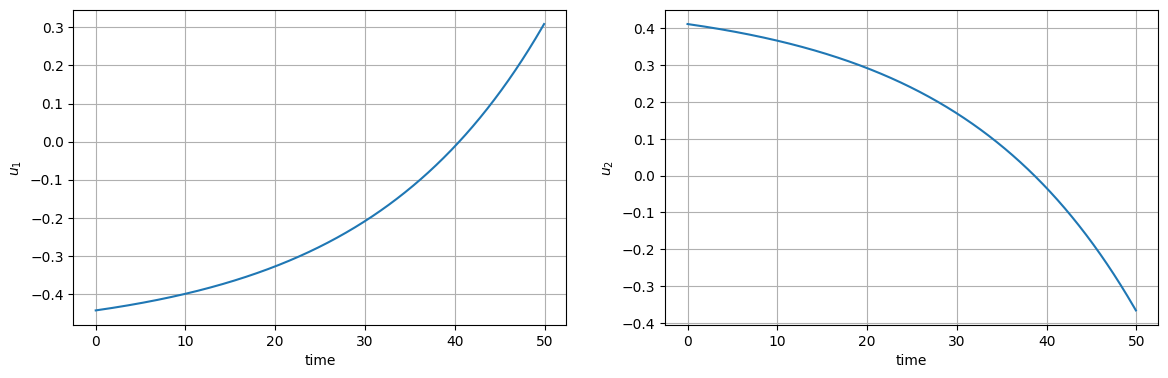

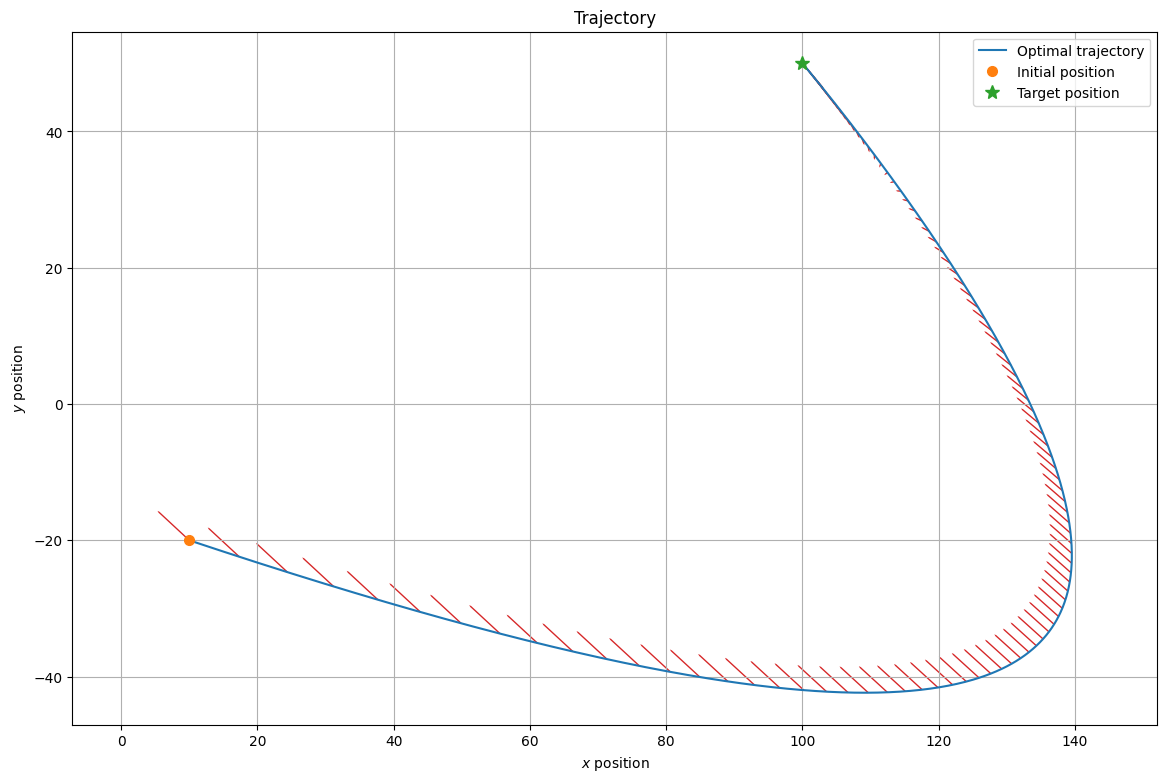

In [3]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_opt[0,:],x_opt[1,:], label='Optimal trajectory')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_opt[0,i], x_opt[1,i], 10*u_opt[0,i], 10*u_opt[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

<br>

---

## Minimum energy control with `cvxpy`

But we will not do this today. Instead, we will just use the original non-standard form with the optimization variables $u_0,\dots,u_{N-1}, x_1,\dots,x_N$, and the original dynamic constraints as linear equality constraints on the optimization variables.

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1
\end{aligned}
$$

We will just put this form into `cvxpy`.


In [4]:
import cvxpy as cp

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]

cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 11 05:25:37 AM: Your problem has 6004 variables, 1002 constraints, and 0 parameters.
(CVXPY) Apr 11 05:25:37 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 11 05:25:37 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 11 05:25:37 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 11 05:25:37 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 11 05:25:37 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

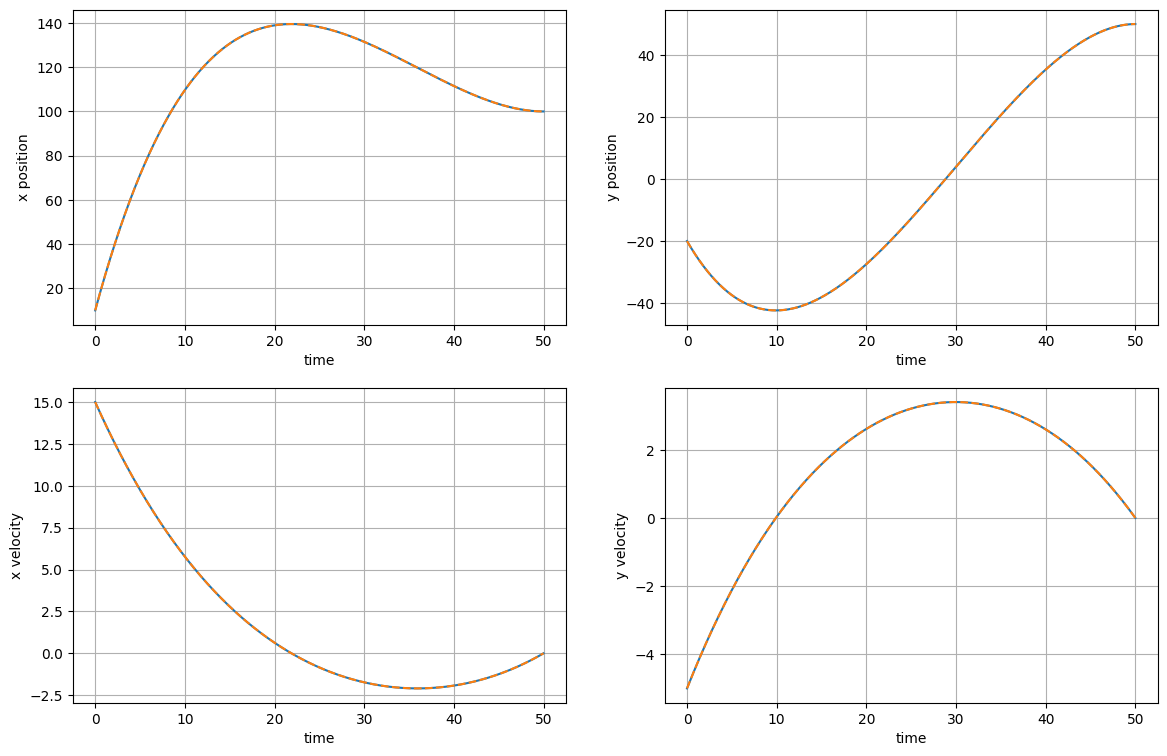

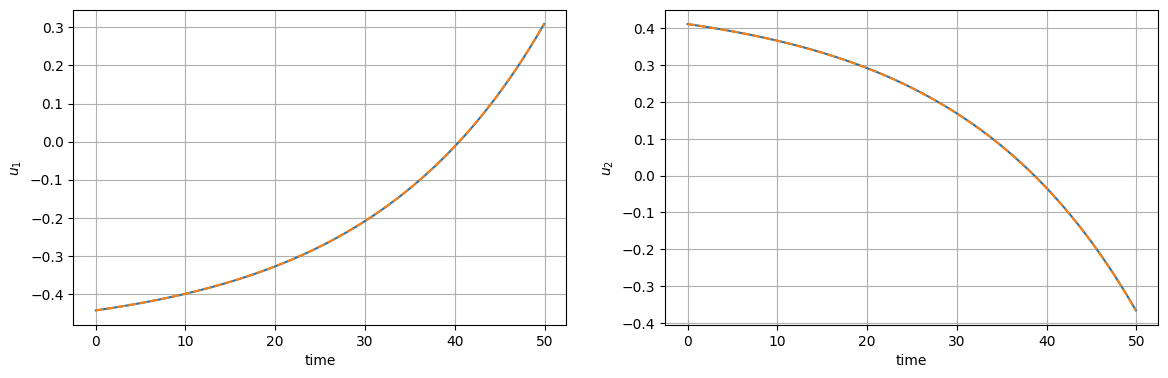

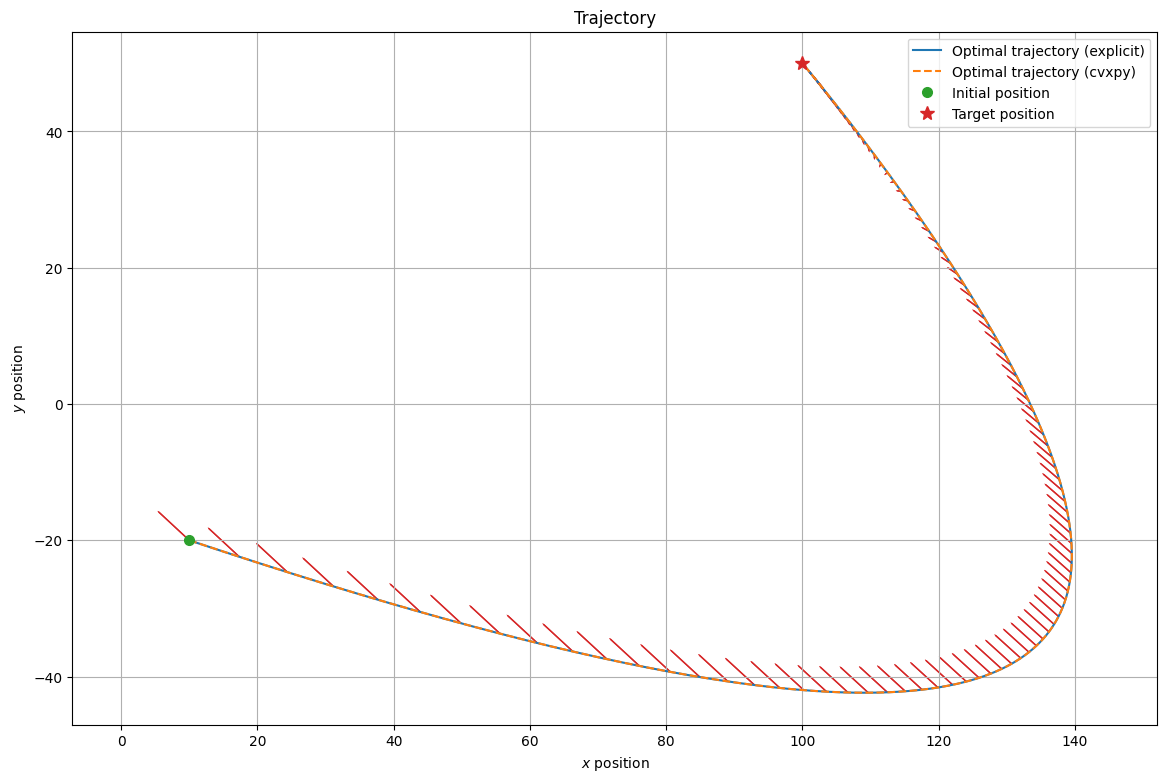

In [5]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_opt[0,:],x_opt[1,:], label='Optimal trajectory (explicit)')
plt.plot(x_cp[0,:],x_cp[1,:], '--', label='Optimal trajectory (cvxpy)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_opt[0,i], x_opt[1,i], 10*u_opt[0,i], 10*u_opt[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
  plt.arrow(x_cp[0,i], x_cp[1,i], 10*u_cp[0,i], 10*u_cp[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

So they just overlap. Someone with an accuracy-OCD could check the followings.

In [6]:
x_diff = x_cp - x_opt
u_diff = u_cp - u_opt

print (np.linalg.norm(x_diff))
print (np.linalg.norm(u_diff))

1.6663589293428932e-06
1.9535047860398453e-08


<br>

---

## Minimum energy control with state limits

Suppose your vehicle is limited to move inside some rectangular area. It is like your robot vaccum searching for the minimum energy trajectory inside your (rectangular) room. 

So the problem can be described by

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N
\end{aligned}
$$

where $C$ chooses the position vector from a state variable,

$$
  C = \bmat{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0}
$$

and $p_\text{lb}$ and $p_\text{ub}$ describe the boundary of the rectangle.


In [7]:
import cvxpy as cp

##########################################
p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
##########################################

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]
    ####################################################
    constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    ####################################################
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 11 05:25:44 AM: Your problem has 6004 variables, 3002 constraints, and 0 parameters.
(CVXPY) Apr 11 05:25:45 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 11 05:25:45 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 11 05:25:45 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 11 05:25:46 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 11 05:25:46 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

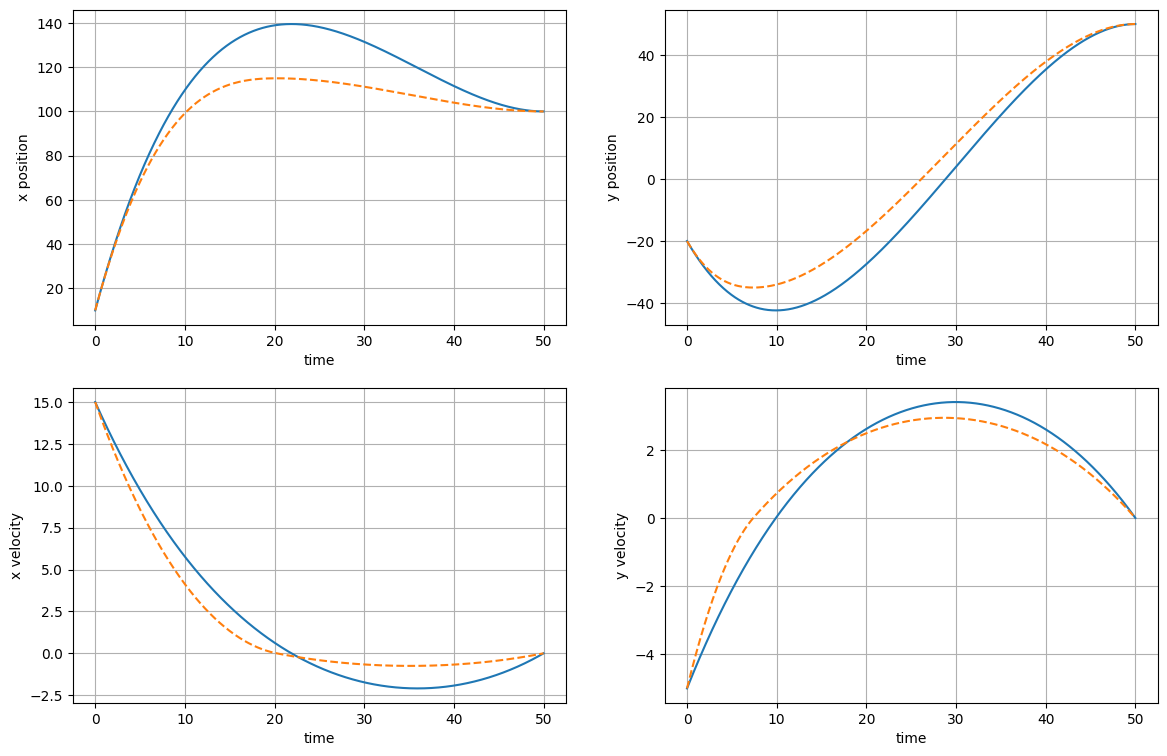

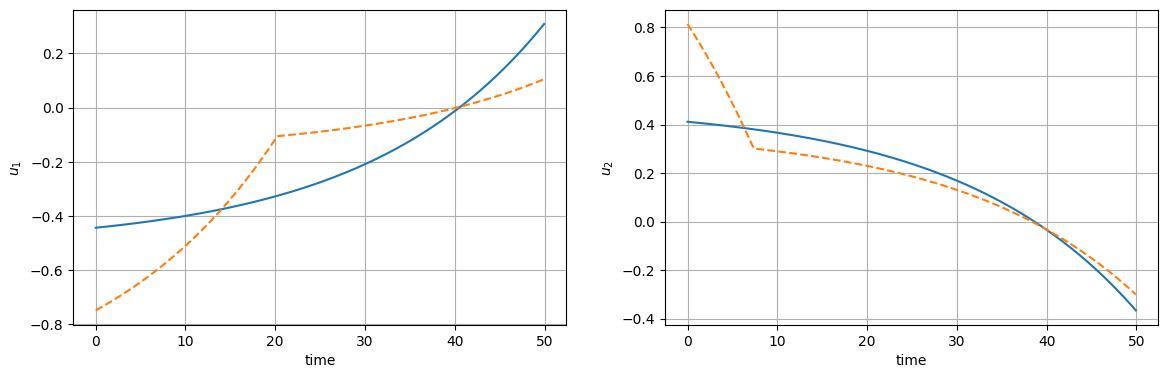

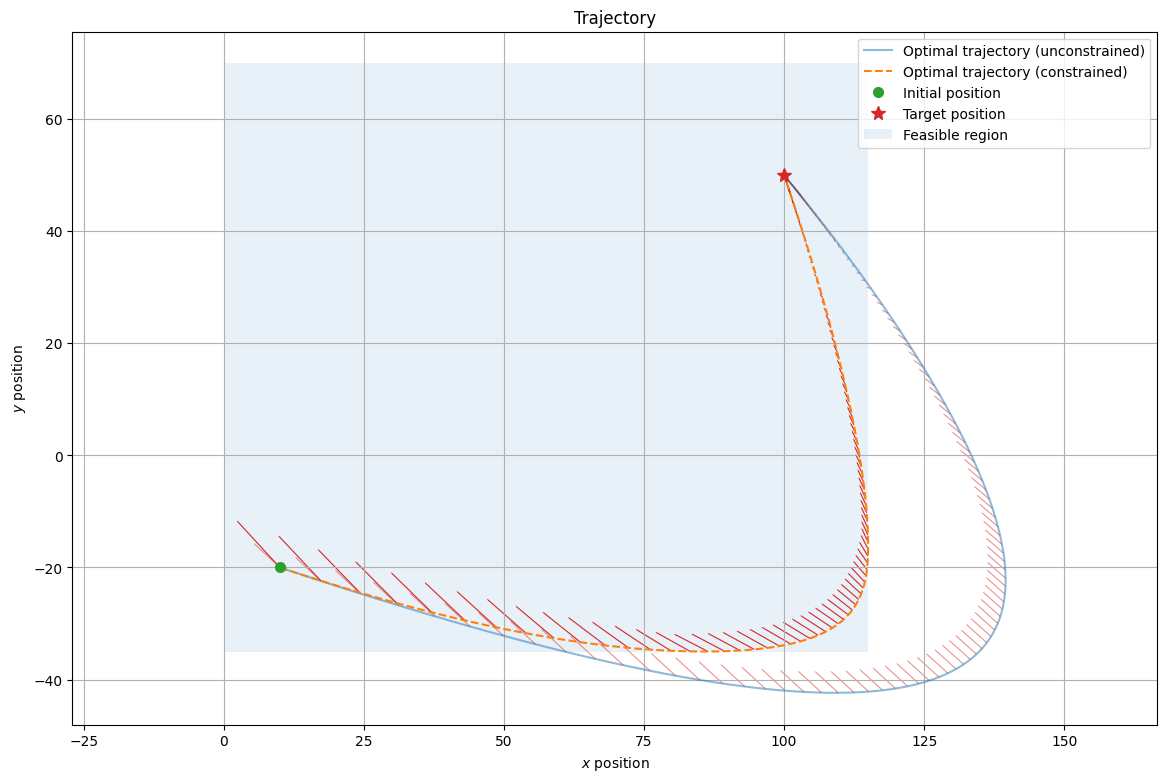

In [8]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_opt[0,:],x_opt[1,:], label='Optimal trajectory (unconstrained)', alpha=0.5)
plt.plot(x_cp[0,:],x_cp[1,:], '--', label='Optimal trajectory (constrained)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_opt[0,i], x_opt[1,i], 10*u_opt[0,i], 10*u_opt[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none', alpha=0.5)
  plt.arrow(x_cp[0,i], x_cp[1,i], 10*u_cp[0,i], 10*u_cp[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

<br>

---

## Minimum energy control with state and control limits

We impose additional constraints on control forces. This is quite natural, since any control system has physical limits on its control forces.

So the problem can be described by

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N \\
  & u_\text{lb} \le u_t \le u_\text{ub}, \qquad & t=0,\dots,N-1
\end{aligned}
$$

Let's just code it.

In [9]:
import cvxpy as cp

#############################
u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7
#############################

p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]
    constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    ############################################
    constr += [ u_lb <= u[:,t], u[:,t] <= u_ub ]
    ############################################
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

x_l2, u_l2 = x_cp, u_cp

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 11 05:26:03 AM: Your problem has 6004 variables, 5002 constraints, and 0 parameters.
(CVXPY) Apr 11 05:26:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 11 05:26:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 11 05:26:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 11 05:26:05 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 11 05:26:05 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

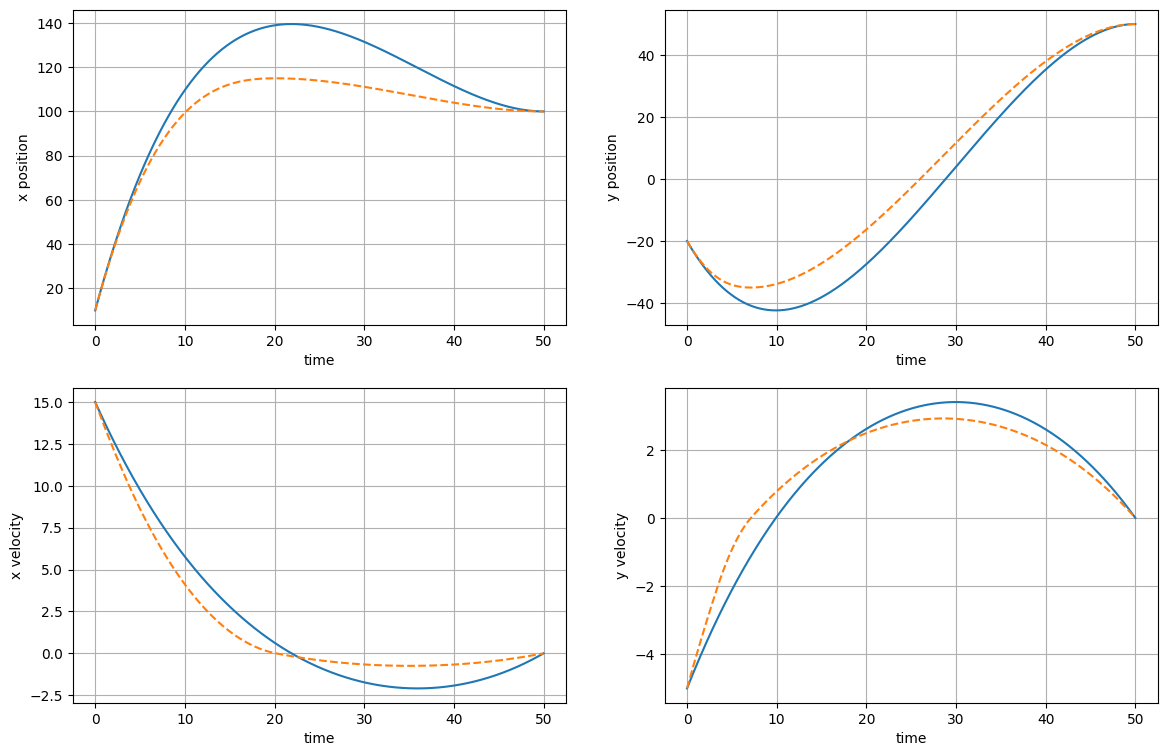

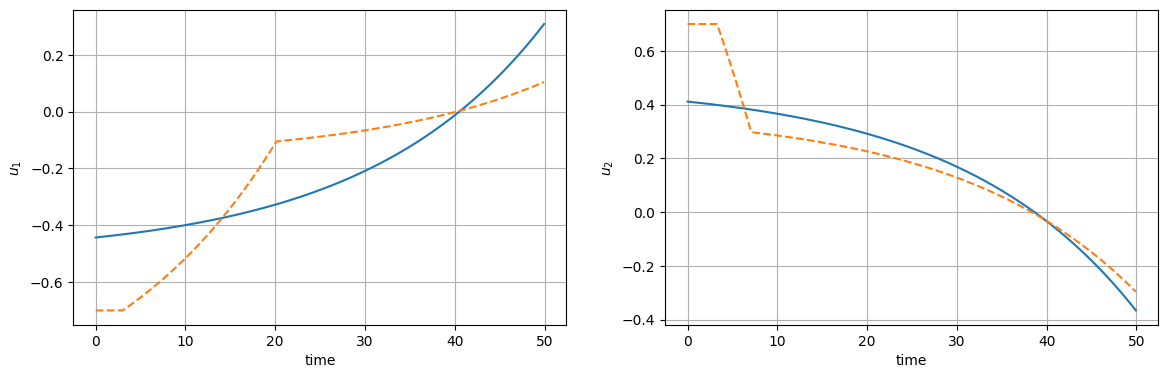

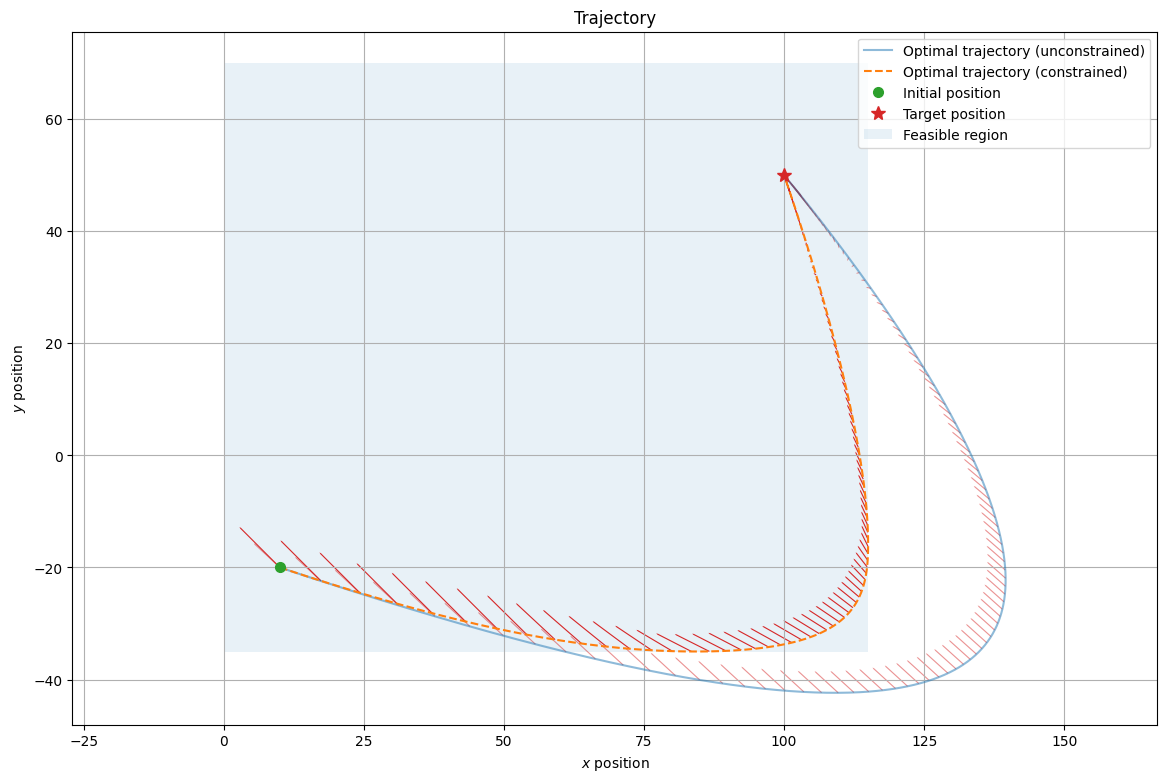

In [10]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_opt[0,:],x_opt[1,:], label='Optimal trajectory (unconstrained)', alpha=0.5)
plt.plot(x_cp[0,:],x_cp[1,:], '--', label='Optimal trajectory (constrained)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_opt[0,i], x_opt[1,i], 10*u_opt[0,i], 10*u_opt[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none', alpha=0.5)
  plt.arrow(x_cp[0,i], x_cp[1,i], 10*u_cp[0,i], 10*u_cp[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()  

<br>

---

## Minimum 'something else' optimal control

We come back to the unconstrained problem.  We will consider different objective functions, in order to examine how the different objectives affect your optimal solutions.

First consider the sum (not squared-sum) of the 2-norm of $u_t$, which can be seen as the $\ell_1$ norm of $\left(\|u_0\|_2, \dots, \|u_{N-1}\|_2\right)$. 
Note that the $\ell_1$ norm of  $\left( \|u_0\|_2, \dots, \|u_{N-1}\|_2 \right)$ is $\|u_0\|_2 + \cdots + \|u_{N-1}\|_2$ and the $\ell_2$ norm of  $\left( \|u_0\|_2, \dots, \|u_{N-1}\|_2 \right)$ is $\left(\|u_0\|_2^2 + \cdots + \|u_{N-1}\|_2^2\right)^{1/2}$

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N \\
  & u_\text{lb} \le u_t \le u_\text{ub}, \qquad & t=0,\dots,N-1
\end{aligned}
$$

In [11]:
import cvxpy as cp

u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7
p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

#############################
obj = cp.norm(cp.norm(u,2,axis=0),1)
#############################
obj = cp.Minimize(obj)

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]
    constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    ############################################
    constr += [ u_lb <= u[:,t], u[:,t] <= u_ub ]
    ############################################
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)  

x_l1, u_l1 = x_cp, u_cp

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 11 05:26:17 AM: Your problem has 6004 variables, 5002 constraints, and 0 parameters.
(CVXPY) Apr 11 05:26:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 11 05:26:17 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 11 05:26:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 11 05:26:17 AM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 11 05:26:17 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

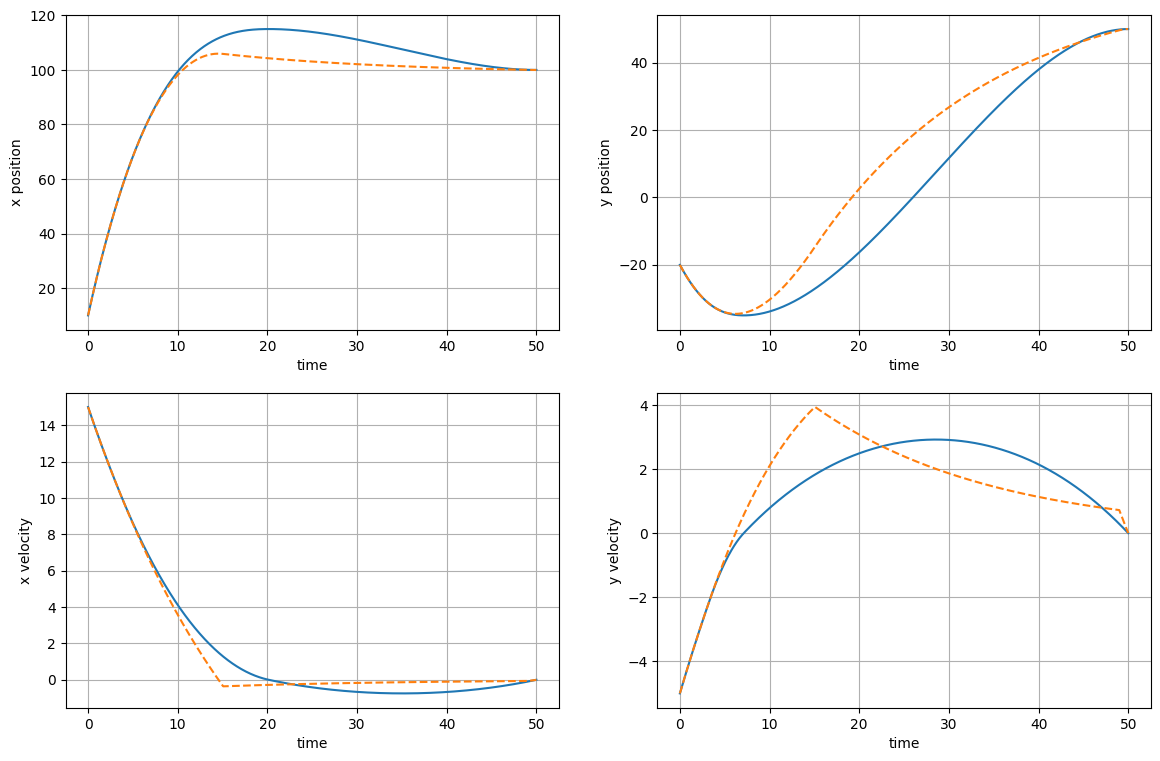

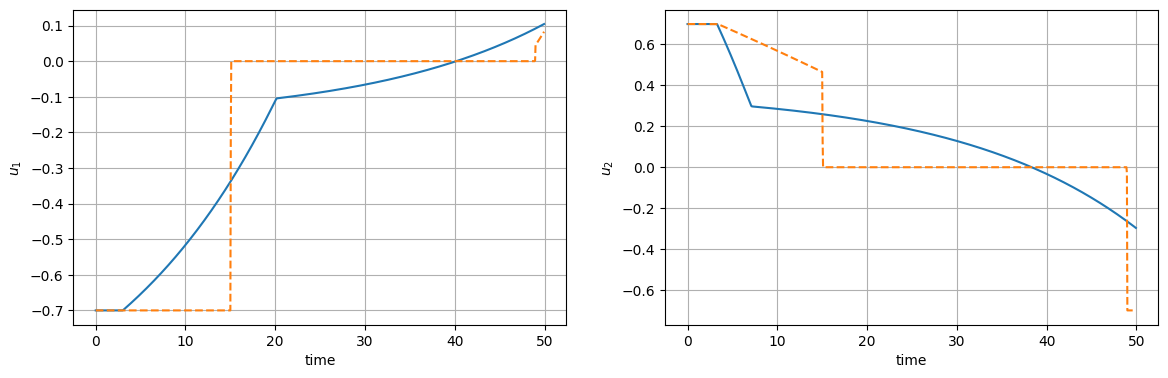

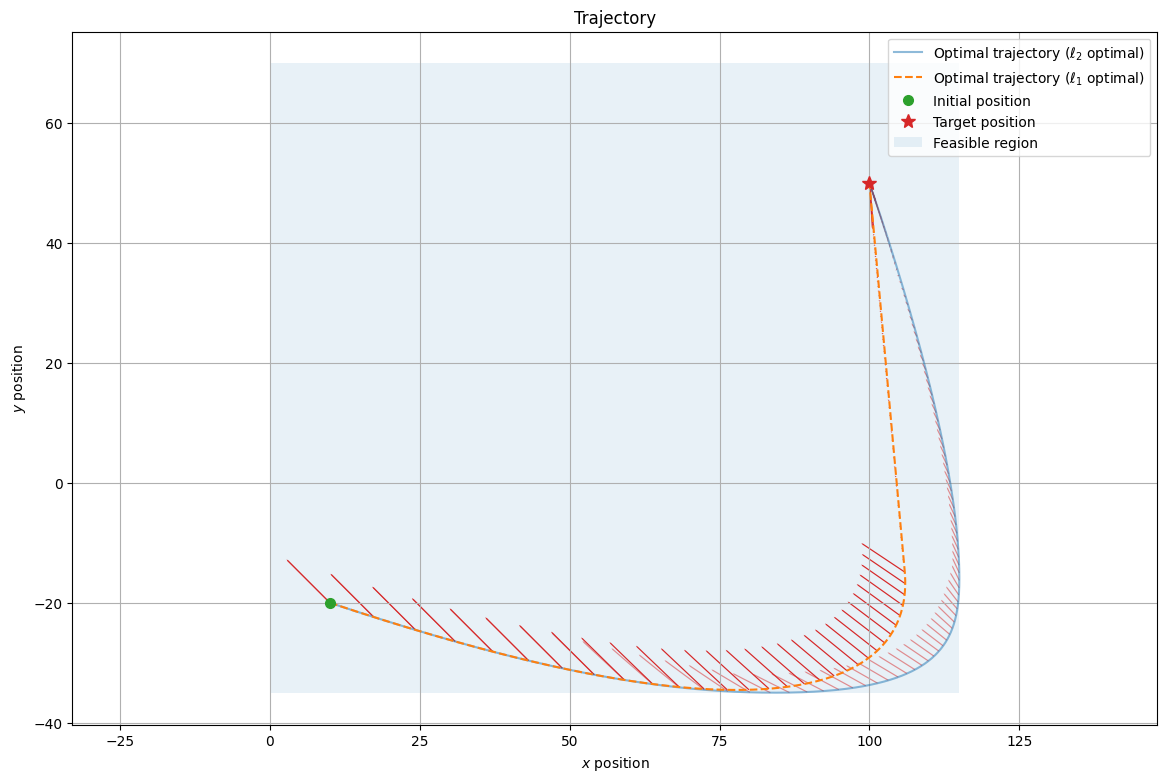

In [12]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_l2[0,:])
plt.plot(ts,x_l1[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_l2[1,:])
plt.plot(ts,x_l1[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_l2[2,:])
plt.plot(ts,x_l1[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_l2[3,:])
plt.plot(ts,x_l1[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_l2[0,:])
plt.plot(ts[:-1],u_l1[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_l2[1,:])
plt.plot(ts[:-1],u_l1[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_l2[0,:],x_l2[1,:], label=r'Optimal trajectory ($\ell_2$ optimal)', alpha=0.5)
plt.plot(x_l1[0,:],x_l1[1,:], '--', label=r'Optimal trajectory ($\ell_1$ optimal)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_l2[0,i], x_l2[1,i], 10*u_l2[0,i], 10*u_l2[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none', alpha=0.5)
  plt.arrow(x_l1[0,i], x_l1[1,i], 10*u_l1[0,i], 10*u_l1[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()  

<br>

How about the maximum of the 2-norm of $u_t$, which can be seen as the $\ell_{\infty}$ norm of $\left(\|u_0\|_2, \dots, \|u_{N-1}\|_2\right)$. 
$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \max_t \|u_t\|_2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N \\
  & u_\text{lb} \le u_t \le u_\text{ub}, \qquad & t=0,\dots,N-1
\end{aligned}
$$

In [13]:
import cvxpy as cp

u_lb = np.array([-1, -1])*0.7
u_ub = np.array([ 1,  1])*0.7
p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

################################################
obj = cp.max(cp.norm(u, 2, axis=0))
obj += 1e-4*cp.norm(cp.norm(u, 2, axis=0),1)
obj = cp.Minimize(obj)
################################################

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A@x[:,t] + B@u[:,t] ]
    constr += [ p_lb <= C@x[:,t+1], C@x[:,t+1] <= p_ub ]
    constr += [ u_lb <= u[:,t], u[:,t] <= u_ub ]
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

x_li, u_li = x_cp, u_cp

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 11 05:26:29 AM: Your problem has 6004 variables, 5002 constraints, and 0 parameters.
(CVXPY) Apr 11 05:26:29 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 11 05:26:29 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 11 05:26:29 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 11 05:26:29 AM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 11 05:26:29 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


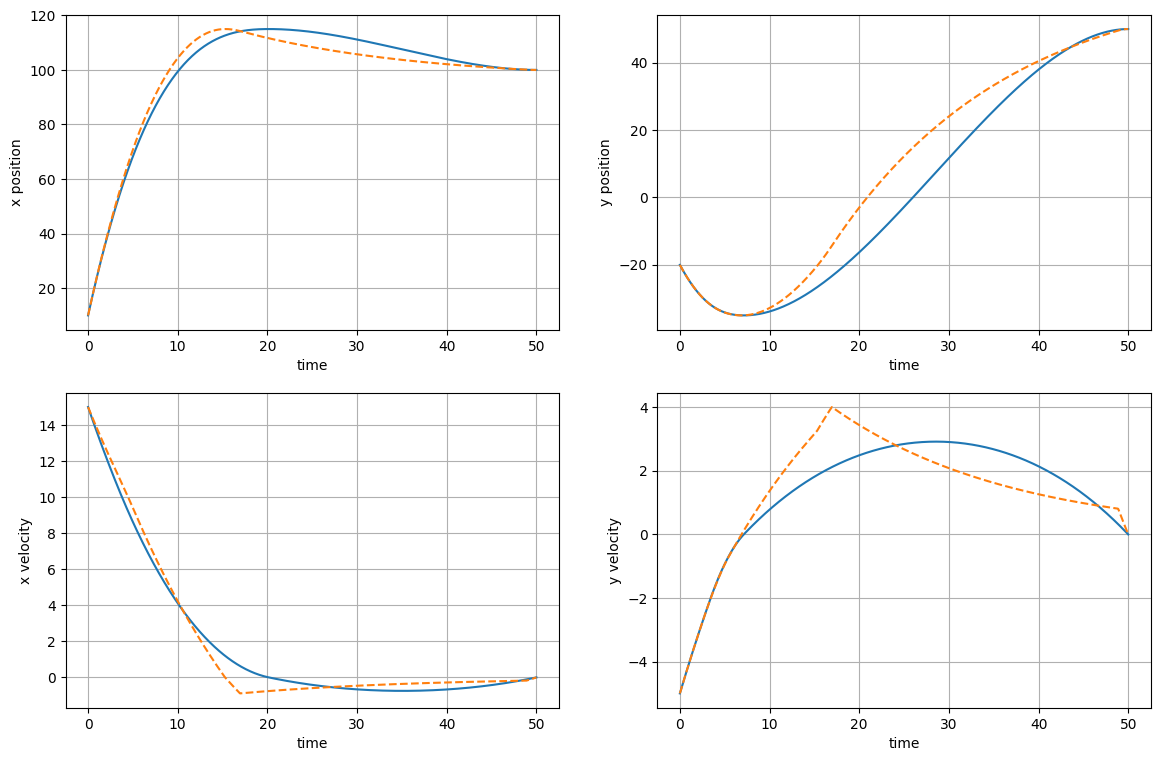

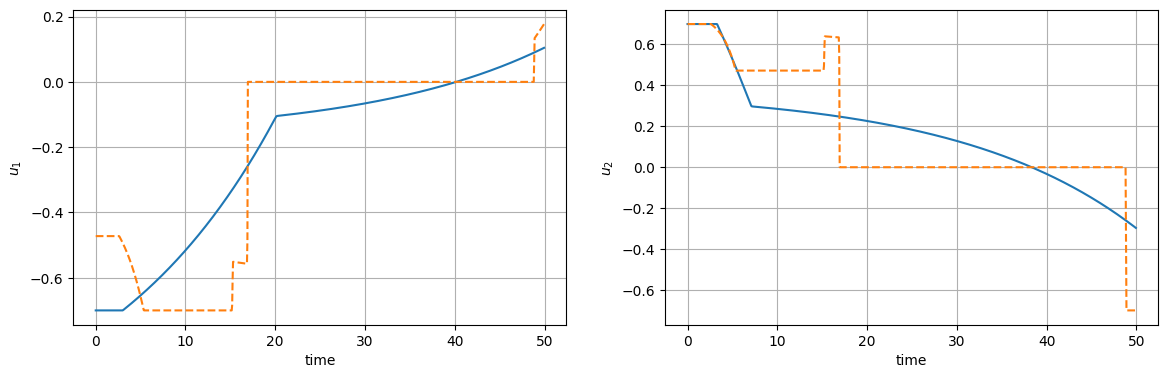

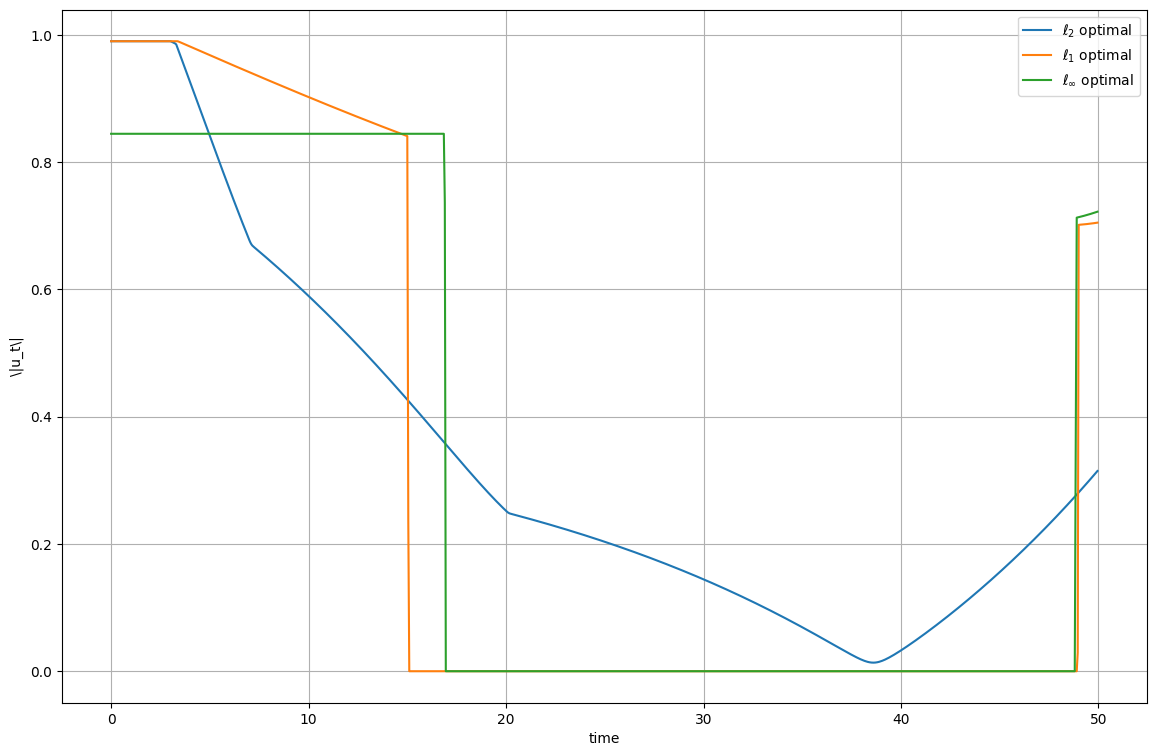

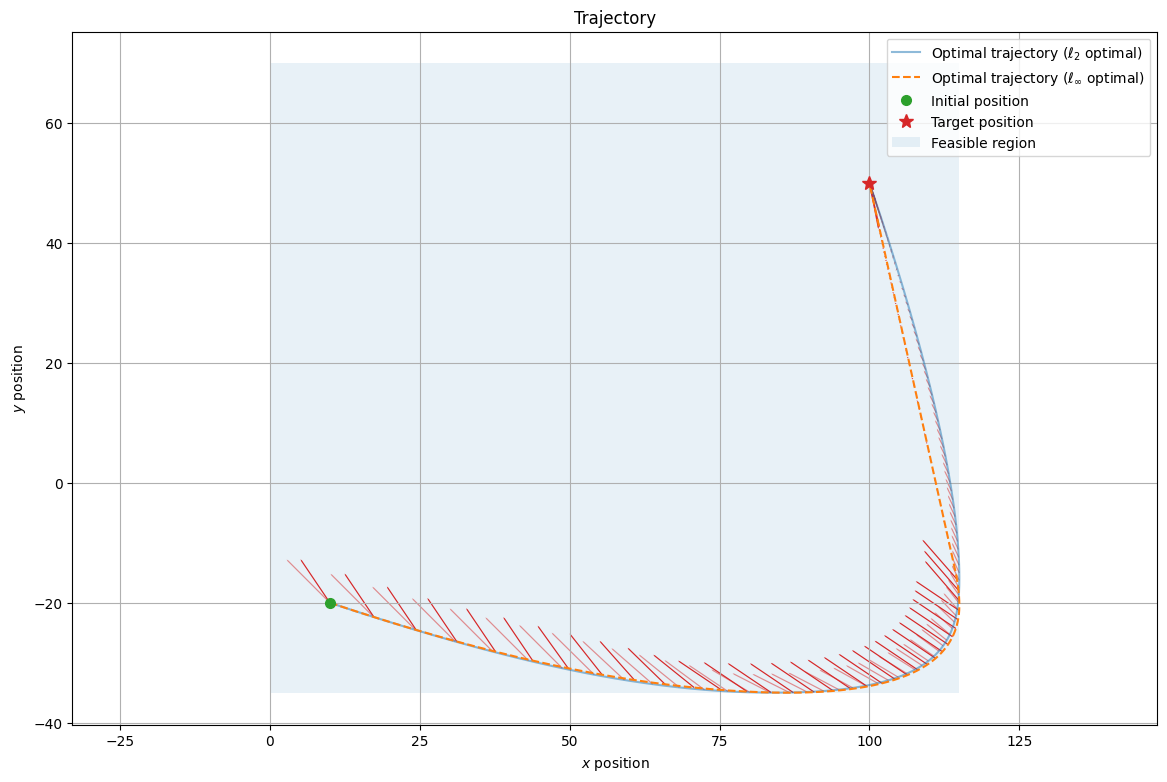

In [14]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_l2[0,:])
plt.plot(ts,x_li[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_l2[1,:])
plt.plot(ts,x_li[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_l2[2,:])
plt.plot(ts,x_li[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_l2[3,:])
plt.plot(ts,x_li[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_l2[0,:])
plt.plot(ts[:-1],u_li[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_l2[1,:])
plt.plot(ts[:-1],u_li[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(ts[:-1],np.linalg.norm(u_l2,2,axis=0), label=r'$\ell_2$ optimal')
plt.plot(ts[:-1],np.linalg.norm(u_l1,2,axis=0), label=r'$\ell_1$ optimal')
plt.plot(ts[:-1],np.linalg.norm(u_li,2,axis=0), label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel(r'\|u_t\|')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_l2[0,:],x_l2[1,:], label=r'Optimal trajectory ($\ell_2$ optimal)', alpha=0.5)
plt.plot(x_li[0,:],x_li[1,:], '--', label=r'Optimal trajectory ($\ell_\infty$ optimal)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x_l2[0,i], x_l2[1,i], 10*u_l2[0,i], 10*u_l2[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none', alpha=0.5)
  plt.arrow(x_li[0,i], x_li[1,i], 10*u_li[0,i], 10*u_li[1,i], head_width=0.2, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()  

<br>

---

In order to get a better intuition behind these effects, let us consider a 1 dimensional unconstrained problem.


In [15]:
N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .0 # damping, 0 is no damping

A1 = np.zeros((2,2))
B1 = np.zeros((2,1))
C1 = np.zeros((1,2))

A1[0,0] = 1
A1[0,1] = (1-gamma*delt/2)*delt
A1[1,1] = 1 - gamma*delt

B1[0,0] = delt**2/2
B1[1,0] = delt

x_01 = np.array([0, 0])
x_des1 = np.array([100, 0])

In [16]:
import cvxpy as cp

x = cp.Variable((2,N+1))  # x_{0},...,x_{N}
u = cp.Variable((1,N))    # u_{0},...,u_{N-1}

obj2 = cp.Minimize(cp.norm(u))

constr = [ x[:,-1] == x_des1, 
           x[:,0]  == x_01    ]
for t in range(N):
    constr += [ x[:,t+1] == A1@x[:,t] + B1@u[:,t] ]
    
cp.Problem(obj2, constr).solve()
x_cp2 = np.array(x.value)
u_cp2 = np.array(u.value)

obj1 = cp.Minimize(cp.norm1(u))
cp.Problem(obj1, constr).solve()
x_cp1 = np.array(x.value)
u_cp1 = np.array(u.value)

obji = cp.Minimize(cp.norm_inf(u))
cp.Problem(obji, constr).solve()
x_cpi = np.array(x.value)
u_cpi = np.array(u.value)

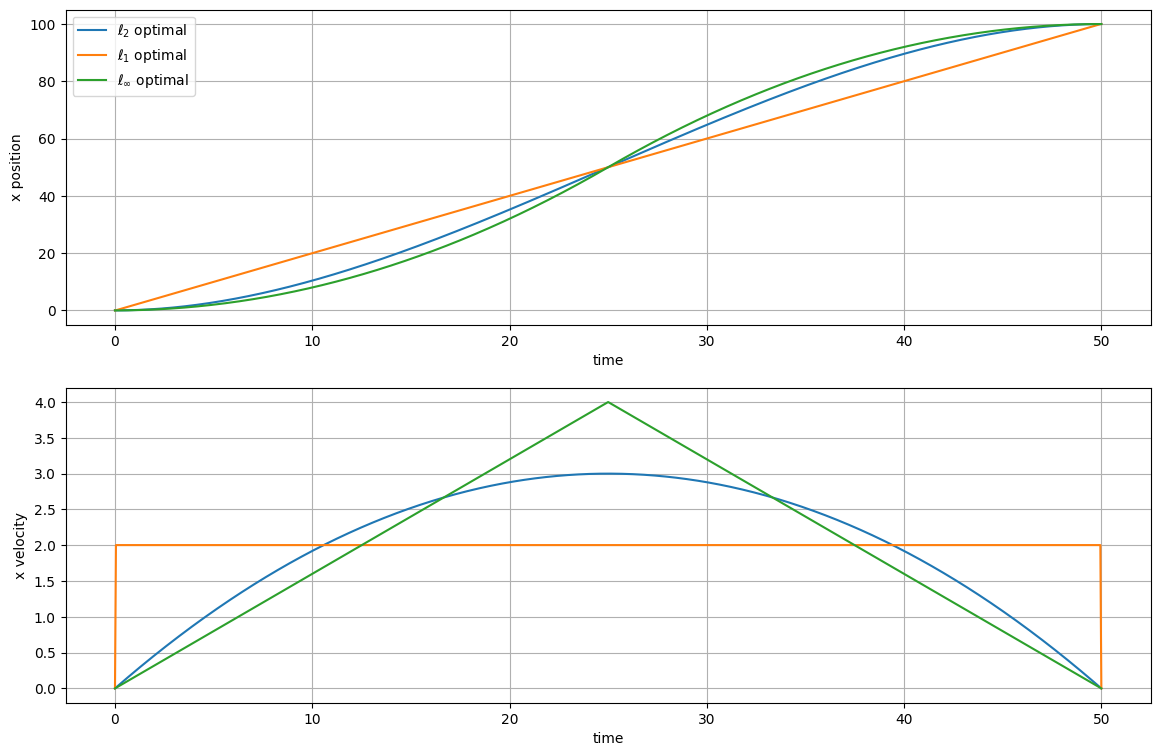

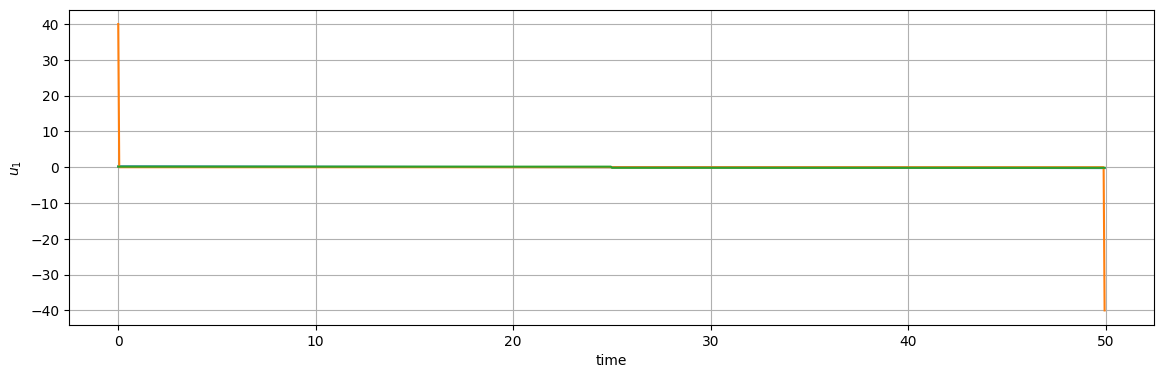

In [17]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x_cp2[0,:], label=r'$\ell_2$ optimal')
plt.plot(ts,x_cp1[0,:], label=r'$\ell_1$ optimal')
plt.plot(ts,x_cpi[0,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x_cp2[1,:], label=r'$\ell_2$ optimal')
plt.plot(ts,x_cp1[1,:], label=r'$\ell_1$ optimal')
plt.plot(ts,x_cpi[1,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],u_cp2[0,:], label=r'$\ell_2$ optimal')
plt.plot(ts[:-1],u_cp1[0,:], label=r'$\ell_1$ optimal')
plt.plot(ts[:-1],u_cpi[0,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.show()

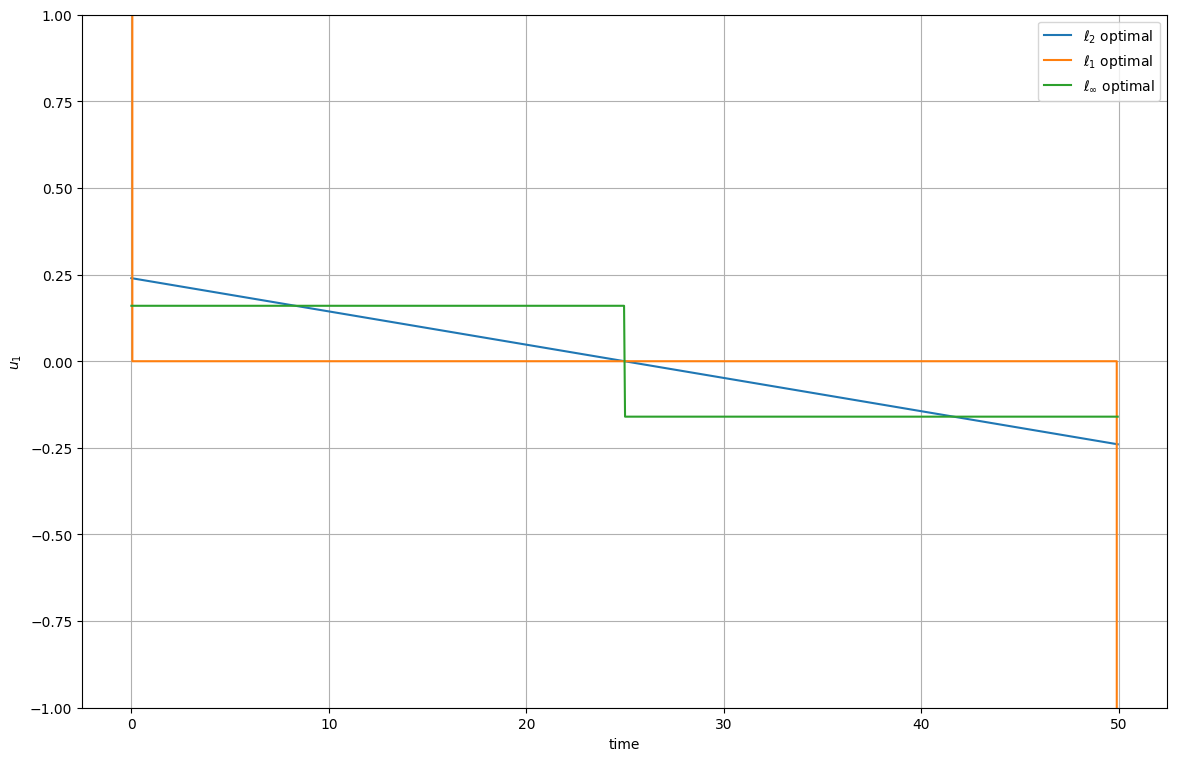

In [18]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(ts[:-1],u_cp2[0,:], label=r'$\ell_2$ optimal')
plt.plot(ts[:-1],u_cp1[0,:], label=r'$\ell_1$ optimal')
plt.plot(ts[:-1],u_cpi[0,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.legend()
plt.ylim(-1, 1)
plt.grid()
plt.show()